In [1]:
# импорт необходимых библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from datetime import date
from datetime import time
from datetime import timedelta
from datetime import datetime

import math 
from dateutil import parser

import seaborn as sns; sns.set()

# Подготовка данных

In [2]:
# считываем исторические данные и помечаем пропуски
SPY = pd.read_csv("spy_minutes_trades.csv", delimiter=";", decimal=".", index_col="*time")
SPY.replace(to_replace=-1, value=np.nan,inplace=True)

In [3]:
# парсим индекс и переводим его из формата строк в формат datetime
dates = [parser.parse(x) for x in SPY.index]
SPY.index = dates

In [4]:
# считываем торговые дни 
days = []
for t in dates:
    if (t.hour==12)&(t.minute==0):
        days.append(t.date())

In [5]:
# создаем и заполняем dataframe с данными для стратегии на каждый день (получасовые доходности, волатильности, объемы)
Strat1 = pd.DataFrame(index=days, columns=['return_1', 'return_12','return_13', 'std_1','vol_1'])

for i in range(len(days)):
    d = days[i]
    if (datetime.combine(d, time(15, 59)) in dates)&(datetime.combine(days[i-1], time(15, 59)) in dates):
    
        Strat1.loc[d]['return_1'] = np.divide(SPY.loc[datetime.combine(d, time(9, 59))]['close'],SPY.loc[datetime.combine(days[i-1], time(15, 59))]['close'])-1
        Strat1.loc[d]['return_12'] = np.divide(SPY.loc[datetime.combine(d, time(15, 29))]['close'],SPY.loc[datetime.combine(d, time(15, 0))]['open'])-1
        
        
        Strat1.loc[d]['return_13'] = np.divide(SPY.loc[datetime.combine(d, time(15, 59))]['close'],SPY.loc[datetime.combine(d, time(15, 30))]['open'])-1
        
        Strat1.loc[d]['std_1'] = (SPY.loc[datetime.combine(d, time(9, 30)):datetime.combine(d, time(10, 0))]['open']).pct_change().std()
        Strat1.loc[d]['vol_1'] = (SPY.loc[datetime.combine(d, time(9, 30)):datetime.combine(d, time(10, 0))]['volume']).sum()

Strat1_clean = Strat1.dropna()

# Тестирование стратегии

In [6]:
# создаем dataframe с результатами работы стратегии и задаем параметры 
Performance = pd.DataFrame(index=Strat1_clean.index, columns=['res1','res2','res3','res4'])

Volatility_percetile = 50
Volume_percetile = 33

std_high_lim = np.percentile(Strat1['std_1'],Volatility_percetile)
vol_high_lim = np.percentile(Strat1['vol_1'],Volume_percetile)

N_years = ((SPY.index[-1]-SPY.index[0]).days/365.25)

In [7]:
# Расчитываем результаты работы всех модификаций стратегии

Performance['res1'] = Strat1_clean['return_13']*np.sign(Strat1_clean['return_1'])

Performance['res2'] = (np.sign(Strat1_clean['return_12'])==np.sign(Strat1_clean['return_1']))*Strat1_clean['return_13']*np.sign(Strat1_clean['return_1'])

Performance['res3'] = (np.sign(Strat1_clean['return_12'])==np.sign(Strat1_clean['return_1']))*np.sign(Strat1_clean['return_1'])*(Strat1_clean['std_1']>std_high_lim)*Strat1_clean['return_13']
Performance['res4'] = (np.sign(Strat1_clean['return_12'])==np.sign(Strat1_clean['return_1']))*np.sign(Strat1_clean['return_1'])*(Strat1_clean['vol_1']>vol_high_lim)*Strat1_clean['return_13']

Performance.replace(to_replace=np.nan, value=0,inplace=True)

# Результаты работы стратегии 

### График

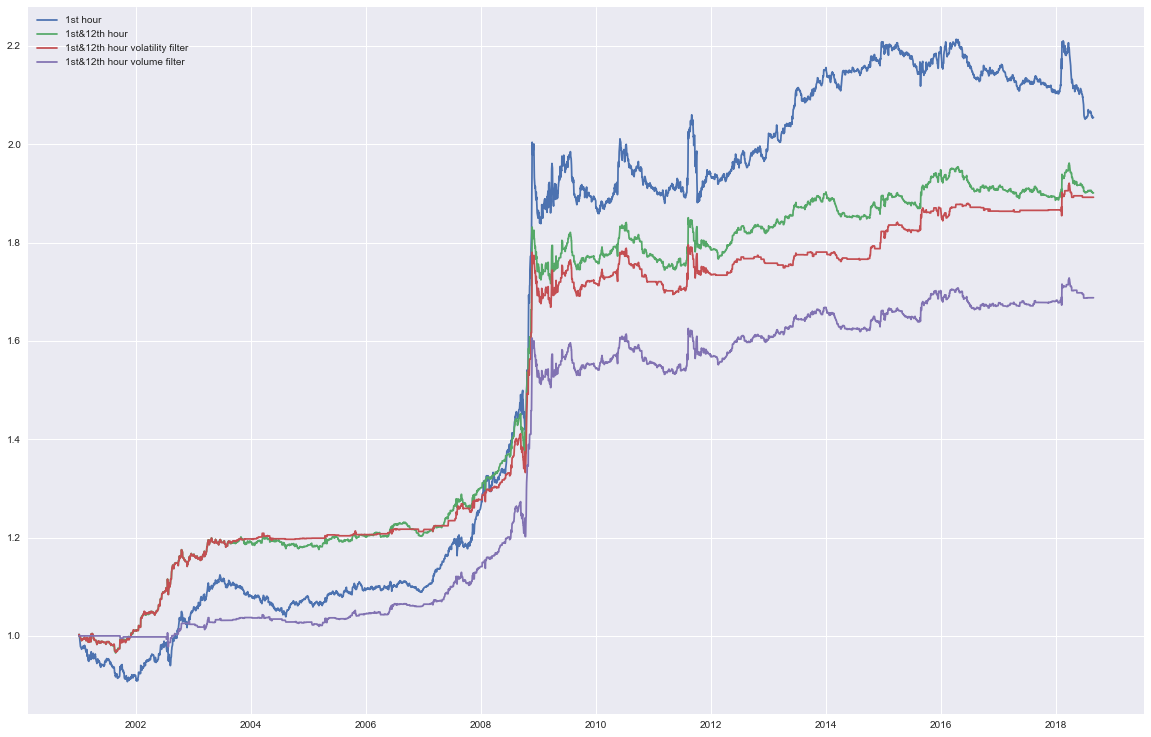

In [8]:
plt.subplots(figsize=(20,13))

plt.plot((Performance['res1']+1).cumprod(), label = '1st hour')
plt.plot((Performance['res2']+1).cumprod(), label = '1st&12th hour')
plt.plot((Performance['res3']+1).cumprod(), label = '1st&12th hour volatility filter')
plt.plot((Performance['res4']+1).cumprod(), label = '1st&12th hour volume filter')

plt.legend()
plt.show()

### Sharpe ratios

In [9]:
((np.prod(1+Performance))**(1/N_years)-1)/(Performance.std()*365**0.5)

res1    0.628123
res2    0.772152
res3    0.805743
res4    0.675621
dtype: float64

### CAGR

In [10]:
((np.prod(1+Performance))**(1/N_years)-1)

res1    0.041634
res2    0.037061
res3    0.036786
res4    0.030094
dtype: float64

### Annual volatility

In [11]:
(Performance.std()*365**0.5)

res1    0.066283
res2    0.047998
res3    0.045655
res4    0.044542
dtype: float64

### Доходность на сделку

In [12]:
np.sum(Performance)/((Performance!=0).sum())*100

res1    0.017479
res2    0.030275
res3    0.059584
res4    0.036579
dtype: float64